從 yahoo finance api 下載 0050 股價

In [1]:
import yfinance as yf
import pandas as pd

In [2]:
def get_historical_data(ticker):
    d = yf.Ticker(ticker)
    df = d.history(period="max")
    df.columns = df.columns.str.lower()
    df.columns = pd.Series(df.columns).str.capitalize().values
    return df.dropna()

In [3]:
df = get_historical_data('0050.TW')

In [4]:
df

,Open,High,Low,Close,Volume,Dividends,Stock splits
Date,,,,,,,
2007-12-31,49.378479,49.579368,49.057056,49.378479,2870000,0.0,0
2008-01-02,48.293678,49.257945,48.213324,48.293678,4975000,0.0,0
2008-01-03,47.490124,47.691013,47.088346,47.490124,7413000,0.0,0
2008-01-04,47.490124,47.691013,46.646391,47.490124,7686000,0.0,0
2008-01-07,45.320530,46.284794,45.240173,45.320530,20041000,0.0,0
...,...,...,...,...,...,...,...
2020-10-30,103.550003,103.599998,102.699997,103.000000,6432187,0.0,0
2020-11-02,103.150002,103.449997,102.300003,103.400002,10063314,0.0,0
2020-11-03,104.199997,104.849998,104.050003,104.599998,4385320,0.0,0


透過 talib 撰寫技術指標

In [5]:
import talib

# 移動平均線 20 日均線與 60 日均線
sma1 = talib.SMA(df.Close, timeperiod=20)
sma2 = talib.SMA(df.Close, timeperiod=60)

# 買賣訊號判斷，20 日均線大於 60 日均線，買入，反之賣出
signal_long = (sma1 > sma2) & (sma1.shift() < sma2.shift())
signal_short = (sma1 < sma2) & (sma1.shift() > sma2.shift())

signal = signal_long.copy()
signal[signal_short] = -1

繪製出 2020 年的 0050 價格、均線、以及買賣訊號

In [6]:
import matplotlib.pyplot as plt

df.Close['2020'].plot()
sma1['2020'].plot()
sma2['2020'].plot()
signal['2020'].astype(int).plot(secondary_y=True)

透過 backtesting 回測和參數優化

In [7]:
from backtesting import Backtest, Strategy

c:\python37\lib\site-packages\backtesting\_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [8]:
class Strategy(Strategy):
    n1 = 125
    n2 = 5
    
    def init(self):
        super().init()
        
        # 移動平均線 20 日均線與 60 日均線
        close = pd.Series(self.data.Close)
        sma1 = talib.SMA(close, timeperiod=self.n1)
        sma2 = talib.SMA(close, timeperiod=self.n2)

        # 買賣訊號判斷，20 日均線大於 60 日均線，買入，反之賣出
        signal_long = (sma1 > sma2) & (sma1.shift() < sma2.shift())
        signal_short = (sma1 < sma2) & (sma1.shift() > sma2.shift())

        # 建立進出訊號
        signal = signal_long
        signal[signal_short] = -1
        
        # 繪製出均線、以及買賣訊號
        self.I(lambda x: sma1, 'sma1')
        self.I(lambda x: sma2, 'sma2')

        # 繪製出買賣訊號
        self.signal = self.I(lambda x: signal, 'signal')

    def next(self):
        super().next()

        entry_size = self.signal[-1]

        if entry_size > 0:
            self.buy()
        elif entry_size < 0:
          for trade in self.trades:
              trade.close()

In [9]:
bt = Backtest(df, Strategy)
result1 = bt.run()
bt.plot()

20 日和 60 日均線，是我們在這個策略中要改變的交易參數，如何自動尋找？
從 5 到 200 裡面挑出 Sharpe ratio 比較好的參數

In [10]:
result2 = bt.optimize(n1=range(5, 200, 10), n2=range(5, 200, 10))

c:\python37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Searching for best of 400 configurations.
  """Entry point for launching an IPython kernel.


In [11]:
result2._strategy

<Strategy Strategy(n1=125,n2=5)>

得到的參數配置是 125 日均線搭配 5 日均線

繪製累積報酬

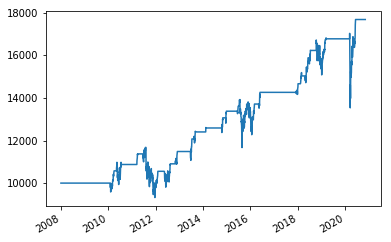

In [12]:
((result1._equity_curve.Equity + result2._equity_curve.Equity)/2).plot()